# Quantum Pump BO Experiment - Hardware Version

## Purpose: Real Device Measurement with Bayesian Optimization

### Features:
- **V8_final_v2 구조**: Dual GP, EI acquisition, Early stopping, 6-panel analysis
- **BO3parameter 하드웨어**: PyVISA, Yokogawa sources, DMM
- **Simulation fallback**: 하드웨어 연결 실패 시 자동 시뮬레이션 모드

### Hardware Requirements:
- 3× Yokogawa voltage sources (G_ENT, G_P, G_EXIT)
- 1× DMM for current measurement
- GPIB interface

In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from pathlib import Path
from datetime import datetime
import warnings
import pandas as pd
import time
warnings.filterwarnings('ignore')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import norm
from scipy.optimize import minimize

# Hardware control
try:
    import pyvisa
    PYVISA_AVAILABLE = True
    print('✅ PyVISA imported successfully')
except ImportError:
    PYVISA_AVAILABLE = False
    print('⚠️ PyVISA not available - Simulation mode only')

print('Quantum Pump BO Experiment - Hardware Version')
print('='*60)

✅ PyVISA imported successfully
Quantum Pump BO Experiment - Hardware Version


In [2]:
# Cell 2: Configuration

class Config:
    """
    Experiment Configuration
    ========================
    Adjust these parameters before running!
    """
    
    # ==================== PHYSICAL CONSTANTS ====================
    e = 1.60217663e-19              # Elementary charge (C)
    f = 0.350e9                     # Pump frequency (Hz) - ADJUST!
    
    @property
    def target_current(self):
        return self.e * self.f      # ~56.08 pA
    
    # ==================== GPIB ADDRESSES ====================
    # Update these based on your instrument rack!
    ADDR_YOKO_ENT  = "GPIB0::11::INSTR"   # G_ENT voltage source
    ADDR_YOKO_P    = "GPIB0::7::INSTR"    # G_P voltage source
    ADDR_YOKO_EXIT = "GPIB0::8::INSTR"    # G_EXIT voltage source
    ADDR_DMM       = "GPIB0::22::INSTR"   # Multimeter
    
    # ==================== VOLTAGE BOUNDS (SAFETY!) ====================
    # Order: [V_ENT, V_P, V_EXIT]
    bounds = np.array([
        [-0.75, -0.50],   # V_ENT range (V)
        [-0.75, -0.50],   # V_P range (V)
        [-0.80, -0.50]    # V_EXIT range (V)
    ])
    
    # ==================== BO PARAMETERS ====================
    n_initial_points = 20           # Random initialization samples
    n_iterations = 80               # Max BO iterations
    early_stop_patience = 25        # Stop after N iterations without improvement
    
    # ==================== FILTER PARAMETERS ====================
    V_ENT_TOLERANCE = 0.03          # ±30mV for V_ENT filtering
    V_P_TOLERANCE = 0.03            # ±30mV for V_P filtering
    
    # ==================== HARDWARE SETTINGS ====================
    SETTLING_TIME = 0.1             # Voltage settling time (s)
    DMM_INTEGRATION_TIME = 1.0      # DMM integration time (s) - for noise reduction
    
    # ==================== MODE SELECTION ====================
    FORCE_SIMULATION = False        # Set True to force simulation mode
    
    # ==================== OUTPUT ====================
    output_dir = Path('./experiment_outputs')
    
    @classmethod
    def print_settings(cls):
        cfg = cls()
        print('='*60)
        print('EXPERIMENT CONFIGURATION')
        print('='*60)
        print(f'Target current:     {cfg.target_current*1e12:.4f} pA')
        print(f'Frequency:          {cls.f/1e9:.6f} GHz')
        print(f'V_ENT bounds:       [{cls.bounds[0,0]:.2f}, {cls.bounds[0,1]:.2f}] V')
        print(f'V_P bounds:         [{cls.bounds[1,0]:.2f}, {cls.bounds[1,1]:.2f}] V')
        print(f'V_EXIT bounds:      [{cls.bounds[2,0]:.2f}, {cls.bounds[2,1]:.2f}] V')
        print(f'Initial points:     {cls.n_initial_points}')
        print(f'Max iterations:     {cls.n_iterations}')
        print(f'Early stop:         {cls.early_stop_patience} iterations')
        print(f'Filter tolerance:   V_ENT±{cls.V_ENT_TOLERANCE*1000:.0f}mV, V_P±{cls.V_P_TOLERANCE*1000:.0f}mV')
        print(f'Force simulation:   {cls.FORCE_SIMULATION}')
        print('='*60)


Config.print_settings()

EXPERIMENT CONFIGURATION
Target current:     56.0762 pA
Frequency:          0.350000 GHz
V_ENT bounds:       [-0.75, -0.50] V
V_P bounds:         [-0.75, -0.50] V
V_EXIT bounds:      [-0.80, -0.50] V
Initial points:     20
Max iterations:     80
Early stop:         25 iterations
Filter tolerance:   V_ENT±30mV, V_P±30mV
Force simulation:   False


In [3]:
# Cell 3: Instrument Controller (Hardware + Simulation)

class InstrumentController:
    """
    Hardware interface for quantum pump experiment.
    Automatically falls back to simulation if hardware unavailable.
    """
    
    def __init__(self, config):
        self.cfg = config
        self.simulation_mode = False
        
        # Check if forced simulation
        if config.FORCE_SIMULATION:
            print('⚠️ FORCE_SIMULATION enabled - using simulation mode')
            self.simulation_mode = True
            self._init_simulation()
            return
        
        # Check PyVISA availability
        if not PYVISA_AVAILABLE:
            print('⚠️ PyVISA not available - using simulation mode')
            self.simulation_mode = True
            self._init_simulation()
            return
        
        # Try to connect to hardware
        try:
            self.rm = pyvisa.ResourceManager()
            
            # Connect to voltage sources
            print('Connecting to instruments...')
            self.yoko_ent = self.rm.open_resource(config.ADDR_YOKO_ENT)
            print(f'  ✅ G_ENT connected: {config.ADDR_YOKO_ENT}')
            
            self.yoko_p = self.rm.open_resource(config.ADDR_YOKO_P)
            print(f'  ✅ G_P connected: {config.ADDR_YOKO_P}')
            
            self.yoko_exit = self.rm.open_resource(config.ADDR_YOKO_EXIT)
            print(f'  ✅ G_EXIT connected: {config.ADDR_YOKO_EXIT}')
            
            self.dmm = self.rm.open_resource(config.ADDR_DMM)
            print(f'  ✅ DMM connected: {config.ADDR_DMM}')
            
            # Configure instruments
            self._configure_instruments()
            
            print(f'\n✅ All instruments connected - HARDWARE MODE')
            print(f'   Target current: {config.target_current*1e12:.4f} pA')
            
        except Exception as e:
            print(f'\n⚠️ Hardware connection failed: {e}')
            print('   Falling back to SIMULATION MODE')
            self.simulation_mode = True
            self._init_simulation()
    
    def _configure_instruments(self):
        """Configure instrument communication settings."""
        for inst in [self.yoko_ent, self.yoko_p, self.yoko_exit]:
            inst.write_termination = '\n'
            inst.read_termination = '\n'
            inst.timeout = 5000  # 5 second timeout
        
        self.dmm.write_termination = '\n'
        self.dmm.read_termination = '\n'
        self.dmm.timeout = 10000  # 10 second timeout for DMM
    
    def _init_simulation(self):
        """Initialize simulation model parameters."""
        # Physics model parameters (same as V8)
        self.Va_base = -0.66
        self.Vb = 0.008
        self.delta2 = 0.10
        self.cross_coupling_ent = 0.30
        self.V_ent_ref = -0.62
        self.V_ent_center = -0.62
        self.ent_width = 0.20
        self.ent_sharpness = 100.0
        self.V_p_center = -0.63
        self.p_width = 0.20
        self.p_sharpness = 80.0
        self.noise_std = 1e-4
        print('   Simulation model initialized')
    
    def set_voltages(self, V_ent, V_p, V_exit):
        """
        Set gate voltages.
        
        Parameters:
        -----------
        V_ent : float - Entrance gate voltage (V)
        V_p : float - Plunger gate voltage (V)
        V_exit : float - Exit gate voltage (V)
        """
        if not self.simulation_mode:
            # Hardware: Send voltage commands to Yokogawa sources
            self.yoko_ent.write(f'S{V_ent:.6f}E')
            self.yoko_p.write(f'S{V_p:.6f}E')
            self.yoko_exit.write(f'S{V_exit:.6f}E')
            
            # Wait for settling
            time.sleep(self.cfg.SETTLING_TIME)
    
    def measure_current(self):
        """
        Measure pump current.
        
        Returns:
        --------
        float : Measured current in Amperes
        """
        if not self.simulation_mode:
            # Hardware: Read from DMM
            try:
                response = self.dmm.query('READ?')
                current = float(response)
                return current
            except Exception as e:
                print(f'⚠️ DMM read error: {e}')
                return 0.0
        else:
            # Simulation: Return None (will be calculated in measure())
            return None
    
    def measure(self, V_ent, V_p, V_exit):
        """
        Complete measurement: set voltages and measure n.
        
        Returns:
        --------
        float : n (electrons per cycle)
        """
        # Set voltages
        self.set_voltages(V_ent, V_p, V_exit)
        
        if not self.simulation_mode:
            # Hardware measurement
            current = self.measure_current()
            n = current / self.cfg.target_current
        else:
            # Simulation
            n = self._simulate_n(V_ent, V_p, V_exit)
        
        return n
    
    def _simulate_n(self, V_ent, V_p, V_exit):
        """Simulate n using physics model (V8 model)."""
        # f_exit (double exponential)
        Va_eff = self.Va_base + self.cross_coupling_ent * (V_ent - self.V_ent_ref)
        arg1 = np.clip(-(V_exit - Va_eff) / self.Vb, -100, 100)
        arg2 = np.clip(-(V_exit - Va_eff + self.delta2) / self.Vb, -100, 100)
        f_exit = np.exp(-np.exp(arg1)) + np.exp(-np.exp(arg2))
        
        # f_entrance (bathtub)
        V_L = self.V_ent_center - self.ent_width / 2
        V_R = self.V_ent_center + self.ent_width / 2
        f_ent = self._sigmoid(self.ent_sharpness * (V_ent - V_L)) * \
                self._sigmoid(-self.ent_sharpness * (V_ent - V_R))
        
        # f_plunger (bathtub)
        V_L_p = self.V_p_center - self.p_width / 2
        V_R_p = self.V_p_center + self.p_width / 2
        f_p = self._sigmoid(self.p_sharpness * (V_p - V_L_p)) * \
              self._sigmoid(-self.p_sharpness * (V_p - V_R_p))
        
        # Combined
        n = f_exit * f_ent * f_p
        n += np.random.normal(0, self.noise_std)
        
        return n
    
    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def close(self):
        """Close all instrument connections."""
        if not self.simulation_mode:
            try:
                self.yoko_ent.close()
                self.yoko_p.close()
                self.yoko_exit.close()
                self.dmm.close()
                self.rm.close()
                print('All instruments disconnected')
            except:
                pass
    
    def get_mode_string(self):
        return 'SIMULATION' if self.simulation_mode else 'HARDWARE'


# Test connection
print('\nTesting instrument connection...')
cfg = Config()
test_instr = InstrumentController(cfg)
print(f'\nMode: {test_instr.get_mode_string()}')
test_instr.close()


Testing instrument connection...
Connecting to instruments...

⚠️ Hardware connection failed: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.
   Falling back to SIMULATION MODE
   Simulation model initialized

Mode: SIMULATION


In [4]:
# Cell 4: Bayesian Optimizer (EI Acquisition)

class BayesianOptimizer:
    """
    Bayesian Optimizer with Expected Improvement (EI) acquisition.
    Dual GP architecture: gp_cost for optimization, gp_n for visualization.
    """
    
    def __init__(self, bounds):
        self.bounds = bounds
        self.dim = len(bounds)
        
        # Kernel for GP
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + \
                      WhiteKernel(noise_level=1e-5)
        
        # Dual GP architecture
        self.gp_cost = GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=10,
            normalize_y=True
        )
        
        self.gp_n = GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=10,
            normalize_y=True
        )
        
        self.X_train = None
        self.y_train = None
        self.n_train = None
        self.is_fitted = False
    
    def fit(self, X, y_cost, n_values):
        """
        Fit both GPs.
        
        Parameters:
        -----------
        X : array - Input points (N x 3)
        y_cost : array - Cost values log10|n-1|
        n_values : array - Raw n values
        """
        self.X_train = np.array(X)
        self.y_train = np.array(y_cost)
        self.n_train = np.array(n_values)
        
        self.gp_cost.fit(self.X_train, self.y_train)
        self.gp_n.fit(self.X_train, self.n_train)
        self.is_fitted = True
    
    def _expected_improvement(self, X):
        """
        Calculate Expected Improvement.
        Returns negative EI (for minimization).
        """
        X = np.atleast_2d(X)
        
        mu, sigma = self.gp_cost.predict(X, return_std=True)
        sigma = np.maximum(sigma, 1e-9)
        
        y_best = np.min(self.y_train)
        
        Z = (y_best - mu) / sigma
        ei = (y_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
        
        return -ei  # Negative for minimization
    
    def suggest_next_point(self, n_candidates=5000):
        """
        Suggest next point by maximizing EI.
        
        Returns:
        --------
        array : Next point to evaluate (V_ENT, V_P, V_EXIT)
        """
        if not self.is_fitted:
            # Random point if not fitted
            return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1])
        
        # Random candidate search
        X_candidates = np.random.uniform(
            self.bounds[:, 0], self.bounds[:, 1],
            size=(n_candidates, self.dim)
        )
        
        ei_values = self._expected_improvement(X_candidates)
        best_idx = np.argmin(ei_values)  # Min of negative EI = Max of EI
        x0 = X_candidates[best_idx]
        
        # Local refinement with L-BFGS-B
        result = minimize(
            lambda x: self._expected_improvement(x.reshape(1, -1))[0],
            x0=x0,
            bounds=self.bounds,
            method='L-BFGS-B'
        )
        
        return result.x
    
    def predict_cost(self, X):
        """Predict cost with uncertainty."""
        return self.gp_cost.predict(np.atleast_2d(X), return_std=True)
    
    def predict_n(self, X):
        """Predict n with uncertainty."""
        return self.gp_n.predict(np.atleast_2d(X), return_std=True)


class EarlyStopping:
    """Early stopping based on cost improvement."""
    
    def __init__(self, patience=25):
        self.patience = patience
        self.best_cost = np.inf
        self.counter = 0
    
    def update(self, cost):
        """
        Update with new cost.
        Returns True if should stop.
        """
        if cost < self.best_cost - 1e-6:
            self.best_cost = cost
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def filter_near_points(X_hist, y_hist, n_hist, V_ent_ref, V_p_ref, config):
    """
    Filter points near reference (V_ent, V_p).
    Used for consistent filtering across all plots.
    """
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    mask = (
        (np.abs(X_hist[:, 0] - V_ent_ref) < config.V_ENT_TOLERANCE) &
        (np.abs(X_hist[:, 1] - V_p_ref) < config.V_P_TOLERANCE)
    )
    
    return X_hist[mask], y_hist[mask], n_hist[mask], mask


print('BayesianOptimizer (EI) and EarlyStopping defined')

BayesianOptimizer (EI) and EarlyStopping defined


In [5]:
# Cell 5: Visualization Functions

def generate_model_pump_map(instr, V_ent_range, V_exit_range, V_p_fixed):
    """
    Generate pump map using model (for comparison in simulation mode).
    In hardware mode, this represents the physics model expectation.
    """
    if not instr.simulation_mode:
        # In hardware mode, we don't have ground truth
        # Return None to indicate no model comparison
        return None, None, None
    
    V_ENT, V_EXIT = np.meshgrid(V_ent_range, V_exit_range)
    n_map = np.zeros_like(V_ENT)
    
    for i in range(len(V_exit_range)):
        for j in range(len(V_ent_range)):
            # Use simulation without noise for ground truth
            noise_backup = instr.noise_std
            instr.noise_std = 0
            n_map[i, j] = instr._simulate_n(V_ENT[i, j], V_p_fixed, V_EXIT[i, j])
            instr.noise_std = noise_backup
    
    return V_ENT, V_EXIT, n_map


def plot_pump_map_analysis(X_hist, y_hist, n_hist, bo, instr, config):
    """
    6-panel pump map analysis.
    """
    fig = plt.figure(figsize=(18, 11))
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
    
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    # Best point
    best_idx = np.argmin(y_hist)
    best_V_ent, best_V_p, best_V_exit = X_hist[best_idx]
    
    # Grid for visualization
    V_ent_range = np.linspace(config.bounds[0, 0], config.bounds[0, 1], 60)
    V_exit_range = np.linspace(config.bounds[2, 0], config.bounds[2, 1], 60)
    
    # Model map (only in simulation mode)
    V_ENT, V_EXIT, n_model = generate_model_pump_map(instr, V_ent_range, V_exit_range, best_V_p)
    
    mode_str = instr.get_mode_string()
    
    # ===== Panel (a): Pump Map =====
    ax1 = fig.add_subplot(gs[0, 0])
    
    if n_model is not None:
        cm1 = ax1.pcolormesh(V_ENT, V_EXIT, n_model, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
        ax1.contour(V_ENT, V_EXIT, n_model, levels=[0.5, 1.0, 1.5], colors=['orange', 'lime', 'cyan'], linewidths=[1.5, 2.5, 1.5])
    
    # Plot BO samples
    mask = np.abs(X_hist[:, 1] - best_V_p) < config.V_P_TOLERANCE
    ax1.scatter(X_hist[mask, 0], X_hist[mask, 2], c=n_hist[mask], cmap='RdYlBu_r', 
                s=40, edgecolors='k', linewidths=0.5, vmin=0, vmax=2, zorder=5)
    ax1.scatter(best_V_ent, best_V_exit, c='red', s=200, marker='*', edgecolors='k', zorder=10, label='Best')
    
    ax1.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax1.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax1.set_title(f'(a) Pump Map at $V_P$={best_V_p:.3f}V\n[{mode_str}]', fontsize=11)
    ax1.legend(fontsize=9)
    if n_model is not None:
        plt.colorbar(cm1, ax=ax1, label=r'$\langle n \rangle$')
    
    # ===== Panel (b): Trans-conductance =====
    ax2 = fig.add_subplot(gs[0, 1])
    if n_model is not None:
        dn_dV = np.abs(np.gradient(n_model, V_exit_range[1] - V_exit_range[0], axis=0))
        cm2 = ax2.pcolormesh(V_ENT, V_EXIT, dn_dV, cmap='hot_r', shading='auto')
        ax2.scatter(best_V_ent, best_V_exit, c='cyan', s=200, marker='*', edgecolors='k', zorder=10)
        plt.colorbar(cm2, ax=ax2, label=r'$|d\langle n \rangle/dV_{EXIT}|$')
    ax2.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax2.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax2.set_title('(b) Trans-conductance (Sensitivity)', fontsize=11)
    
    # ===== Panel (c): Error Map =====
    ax3 = fig.add_subplot(gs[0, 2])
    if n_model is not None:
        delta_n = np.clip(np.abs(n_model - 1), 1e-10, None)
        cm3 = ax3.pcolormesh(V_ENT, V_EXIT, delta_n, cmap='hot_r', shading='auto', norm=LogNorm(vmin=1e-6, vmax=1))
        cs = ax3.contour(V_ENT, V_EXIT, delta_n, levels=[1e-4, 1e-3, 1e-2], colors=['cyan', 'lime', 'yellow'], linewidths=2)
        ax3.scatter(best_V_ent, best_V_exit, c='blue', s=200, marker='*', edgecolors='k', zorder=10)
        plt.colorbar(cm3, ax=ax3, label=r'$|\delta I_p|$')
    ax3.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax3.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax3.set_title(r'(c) Error Map $|\delta I_p| = |n-1|$', fontsize=11)
    
    # ===== Panel (d): Cross-coupling curves =====
    ax4 = fig.add_subplot(gs[1, 0])
    if n_model is not None:
        V_ent_samples = [-0.68, -0.64, -0.60, -0.56]
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(V_ent_samples)))
        for V_ent, c in zip(V_ent_samples, colors):
            idx = np.argmin(np.abs(V_ent_range - V_ent))
            ax4.plot(V_exit_range, n_model[:, idx], color=c, lw=2, label=f'$V_{{ENT}}$={V_ent}V')
    ax4.axhline(1, color='gray', ls='--', alpha=0.5)
    ax4.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax4.set_ylabel(r'$\langle n \rangle$', fontsize=12)
    ax4.set_title('(d) Cross-coupling: n vs $V_{EXIT}$', fontsize=11)
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # ===== Panel (e): Error vs V_EXIT =====
    ax5 = fig.add_subplot(gs[1, 1])
    
    # Filtered BO points
    X_filt, y_filt, n_filt, mask_filt = filter_near_points(X_hist, y_hist, n_hist, best_V_ent, best_V_p, config)
    
    if n_model is not None:
        idx_ent = np.argmin(np.abs(V_ent_range - best_V_ent))
        delta_model = np.abs(n_model[:, idx_ent] - 1)
        ax5.semilogy(V_exit_range, delta_model, 'r-', lw=2, label='Model')
    
    if len(X_filt) > 0:
        delta_bo = np.abs(n_filt - 1)
        ax5.semilogy(X_filt[:, 2], delta_bo, 'bo', ms=6, alpha=0.7, label=f'BO ({len(X_filt)} pts)')
    
    ax5.axhline(1e-3, color='orange', ls='--', label=r'$10^{-3}$')
    ax5.axhline(1e-6, color='green', ls='--', label=r'$10^{-6}$')
    ax5.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax5.set_ylabel(r'$|\delta I_p|$', fontsize=12)
    ax5.set_title(f'(e) Error at Best $V_{{ENT}}$={best_V_ent:.3f}V\nFilter: ±{config.V_ENT_TOLERANCE*1000:.0f}mV, ±{config.V_P_TOLERANCE*1000:.0f}mV', fontsize=10)
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(1e-8, 1e1)
    
    # ===== Panel (f): Optimization History =====
    ax6 = fig.add_subplot(gs[1, 2])
    iterations = np.arange(len(y_hist))
    ax6.plot(iterations, y_hist, 'o-', color='steelblue', ms=4, alpha=0.6, label='Cost')
    
    # Best-so-far
    best_so_far = np.minimum.accumulate(y_hist)
    ax6.plot(iterations, best_so_far, 'r-', lw=2, label='Best so far')
    
    # Mark phases
    ax6.axvline(config.n_initial_points, color='gray', ls='--', alpha=0.5, label='Init→BO')
    
    ax6.set_xlabel('Iteration', fontsize=12)
    ax6.set_ylabel(r'Cost $\log_{10}|n-1|$', fontsize=12)
    ax6.set_title(f'(f) Optimization History\nBest: {np.min(y_hist):.2f} at iter {best_idx}', fontsize=11)
    ax6.legend(fontsize=8)
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle(f'Quantum Pump BO Analysis [{mode_str}] - {len(y_hist)} measurements', fontsize=14, fontweight='bold')
    
    # Save
    config.output_dir.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = config.output_dir / f'pump_analysis_{mode_str}_{timestamp}.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filepath}')
    
    return fig


def plot_error_analysis_with_GP(X_hist, y_hist, n_hist, bo, instr, config):
    """
    3-panel error analysis with GP predictions.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    best_idx = np.argmin(y_hist)
    best_V_ent, best_V_p, best_V_exit = X_hist[best_idx]
    
    # Filter points
    X_filt, y_filt, n_filt, _ = filter_near_points(X_hist, y_hist, n_hist, best_V_ent, best_V_p, config)
    
    V_exit_range = np.linspace(config.bounds[2, 0], config.bounds[2, 1], 100)
    X_pred = np.column_stack([np.full_like(V_exit_range, best_V_ent),
                              np.full_like(V_exit_range, best_V_p),
                              V_exit_range])
    
    mode_str = instr.get_mode_string()
    
    # ===== Panel (a): n vs V_EXIT =====
    ax = axes[0]
    
    # Model (simulation only)
    if instr.simulation_mode:
        n_model = np.array([instr._simulate_n(best_V_ent, best_V_p, v) for v in V_exit_range])
        # Remove noise for clean curve
        noise_backup = instr.noise_std
        instr.noise_std = 0
        n_model_clean = np.array([instr._simulate_n(best_V_ent, best_V_p, v) for v in V_exit_range])
        instr.noise_std = noise_backup
        ax.plot(V_exit_range, n_model_clean, 'r-', lw=2.5, label='Model', zorder=2)
    
    # GP prediction
    n_gp, n_std = bo.predict_n(X_pred)
    ax.plot(V_exit_range, n_gp, 'g-', lw=2, label='GP (gp_n)', zorder=3)
    ax.fill_between(V_exit_range, n_gp - 2*n_std, n_gp + 2*n_std, color='green', alpha=0.2, label='GP ±2σ')
    
    # BO measurements
    if len(X_filt) > 0:
        ax.scatter(X_filt[:, 2], n_filt, c='blue', s=50, edgecolors='k', zorder=5, label=f'BO ({len(X_filt)})')
    
    ax.axhline(1, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$\langle n \rangle$', fontsize=12)
    ax.set_title(f'(a) n vs $V_{{EXIT}}$\n$V_{{ENT}}$={best_V_ent:.3f}V, $V_P$={best_V_p:.3f}V', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # ===== Panel (b): |δIp| vs V_EXIT =====
    ax = axes[1]
    
    if instr.simulation_mode:
        delta_model = np.clip(np.abs(n_model_clean - 1), 1e-12, None)
        ax.semilogy(V_exit_range, delta_model, 'r-', lw=2.5, label='Model', zorder=2)
    
    # GP prediction for cost
    cost_gp, cost_std = bo.predict_cost(X_pred)
    delta_gp = 10**cost_gp
    ax.semilogy(V_exit_range, delta_gp, 'g-', lw=2, label='GP (gp_cost)', zorder=3)
    
    # BO measurements
    if len(X_filt) > 0:
        delta_bo = np.abs(n_filt - 1)
        ax.semilogy(X_filt[:, 2], delta_bo, 'bo', ms=8, mec='k', zorder=5, label=f'BO ({len(X_filt)})')
    
    ax.axhline(1e-3, color='orange', ls='--', label=r'$10^{-3}$')
    ax.axhline(1e-6, color='purple', ls='--', label=r'$10^{-6}$')
    
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$|\delta I_p|$', fontsize=12)
    ax.set_title('(b) Error vs $V_{EXIT}$', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_ylim(1e-8, 1e1)
    
    # ===== Panel (c): GP Variance =====
    ax = axes[2]
    
    ax.semilogy(V_exit_range, cost_std**2, 'g-', lw=2, label='GP variance $\sigma^2$')
    
    if len(X_filt) > 0:
        _, pt_std = bo.predict_cost(X_filt)
        ax.semilogy(X_filt[:, 2], pt_std**2, 'ro', ms=8, mec='k', label=f'At BO pts ({len(X_filt)})')
    
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'GP Variance $\sigma^2$', fontsize=12)
    ax.set_title('(c) GP Uncertainty', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, which='both')
    
    plt.suptitle(f'Error Analysis with GP [{mode_str}]\nFilter: $V_{{ENT}}$±{config.V_ENT_TOLERANCE*1000:.0f}mV, $V_P$±{config.V_P_TOLERANCE*1000:.0f}mV → {len(X_filt)} points', fontsize=12)
    plt.tight_layout()
    
    # Save
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = config.output_dir / f'error_analysis_{mode_str}_{timestamp}.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filepath}')
    
    return fig


print('Visualization functions defined')

Visualization functions defined


In [6]:
# Cell 6: Main Experiment Loop

def run_experiment(config=None):
    """
    Run Bayesian Optimization experiment.
    Works with both hardware and simulation.
    """
    if config is None:
        config = Config()
    
    print('='*70)
    print('QUANTUM PUMP BAYESIAN OPTIMIZATION EXPERIMENT')
    print('='*70)
    config.print_settings()
    
    # Initialize instruments
    instr = InstrumentController(config)
    mode_str = instr.get_mode_string()
    print(f'\n>>> Running in {mode_str} mode <<<\n')
    
    # Initialize optimizer
    bo = BayesianOptimizer(config.bounds)
    early_stop = EarlyStopping(patience=config.early_stop_patience)
    
    # Data storage
    X_hist = []
    y_hist = []  # cost = log10|n-1|
    n_hist = []  # raw n values
    
    # Create output directory
    config.output_dir.mkdir(parents=True, exist_ok=True)
    
    # Header
    print(f'{"Iter":>5} {"Phase":>8} {"V_ENT":>10} {"V_P":>10} {"V_EXIT":>10} {"n":>12} {"Cost":>10} {"Best":>10}')
    print('-'*85)
    
    total_iterations = config.n_initial_points + config.n_iterations
    stopped_early = False
    
    for i in range(total_iterations):
        # Determine phase
        if i < config.n_initial_points:
            phase = 'Init'
            # Random sampling
            x_next = np.random.uniform(config.bounds[:, 0], config.bounds[:, 1])
        else:
            phase = 'BO'
            # Fit GP and suggest next point
            bo.fit(X_hist, y_hist, n_hist)
            x_next = bo.suggest_next_point()
        
        V_ent, V_p, V_exit = x_next
        
        # Measure
        n = instr.measure(V_ent, V_p, V_exit)
        
        # Calculate cost
        epsilon = 1e-12
        cost = np.log10(np.abs(n - 1) + epsilon)
        
        # Store
        X_hist.append(x_next)
        y_hist.append(cost)
        n_hist.append(n)
        
        # Best so far
        best_cost = np.min(y_hist)
        
        # Print
        print(f'{i:>5} {phase:>8} {V_ent:>10.4f} {V_p:>10.4f} {V_exit:>10.4f} {n:>12.6f} {cost:>10.2f} {best_cost:>10.2f}')
        
        # Early stopping (only in BO phase)
        if phase == 'BO' and early_stop.update(cost):
            print(f'\n⚠️ Early stopping triggered at iteration {i}')
            print(f'   No improvement for {config.early_stop_patience} iterations')
            stopped_early = True
            break
    
    # Final GP fit
    bo.fit(X_hist, y_hist, n_hist)
    
    # Results
    best_idx = np.argmin(y_hist)
    best_x = X_hist[best_idx]
    best_cost = y_hist[best_idx]
    best_n = n_hist[best_idx]
    
    print('\n' + '='*70)
    print('OPTIMIZATION COMPLETE')
    print('='*70)
    print(f'Mode:           {mode_str}')
    print(f'Total measurements: {len(y_hist)}')
    print(f'Early stopped:  {stopped_early}')
    print(f'\nBest Parameters:')
    print(f'  V_ENT:  {best_x[0]:.6f} V')
    print(f'  V_P:    {best_x[1]:.6f} V')
    print(f'  V_EXIT: {best_x[2]:.6f} V')
    print(f'\nBest Results:')
    print(f'  n:     {best_n:.6f}')
    print(f'  |n-1|: {np.abs(best_n-1):.2e}')
    print(f'  Cost:  {best_cost:.4f}')
    print('='*70)
    
    # Close instruments
    instr.close()
    
    return X_hist, y_hist, n_hist, bo, instr, config


# Run experiment
X_hist, y_hist, n_hist, bo, instr, cfg = run_experiment()

QUANTUM PUMP BAYESIAN OPTIMIZATION EXPERIMENT
EXPERIMENT CONFIGURATION
Target current:     56.0762 pA
Frequency:          0.350000 GHz
V_ENT bounds:       [-0.75, -0.50] V
V_P bounds:         [-0.75, -0.50] V
V_EXIT bounds:      [-0.80, -0.50] V
Initial points:     20
Max iterations:     80
Early stop:         25 iterations
Filter tolerance:   V_ENT±30mV, V_P±30mV
Force simulation:   False
Connecting to instruments...

⚠️ Hardware connection failed: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.
   Falling back to SIMULATION MODE
   Simulation model initialized

>>> Running in SIMULATION mode <<<

 Iter    Phase      V_ENT        V_P     V_EXIT            n       Cost       Best
-------------------------------------------------------------------------------------
    0     Init    -0.5971    -0.7174    -0.6271     1.436315      -0.36      -0.36
    1     Init    -0.5708    -0.6532    -0.5752     1.

Generating 6-panel pump map analysis...


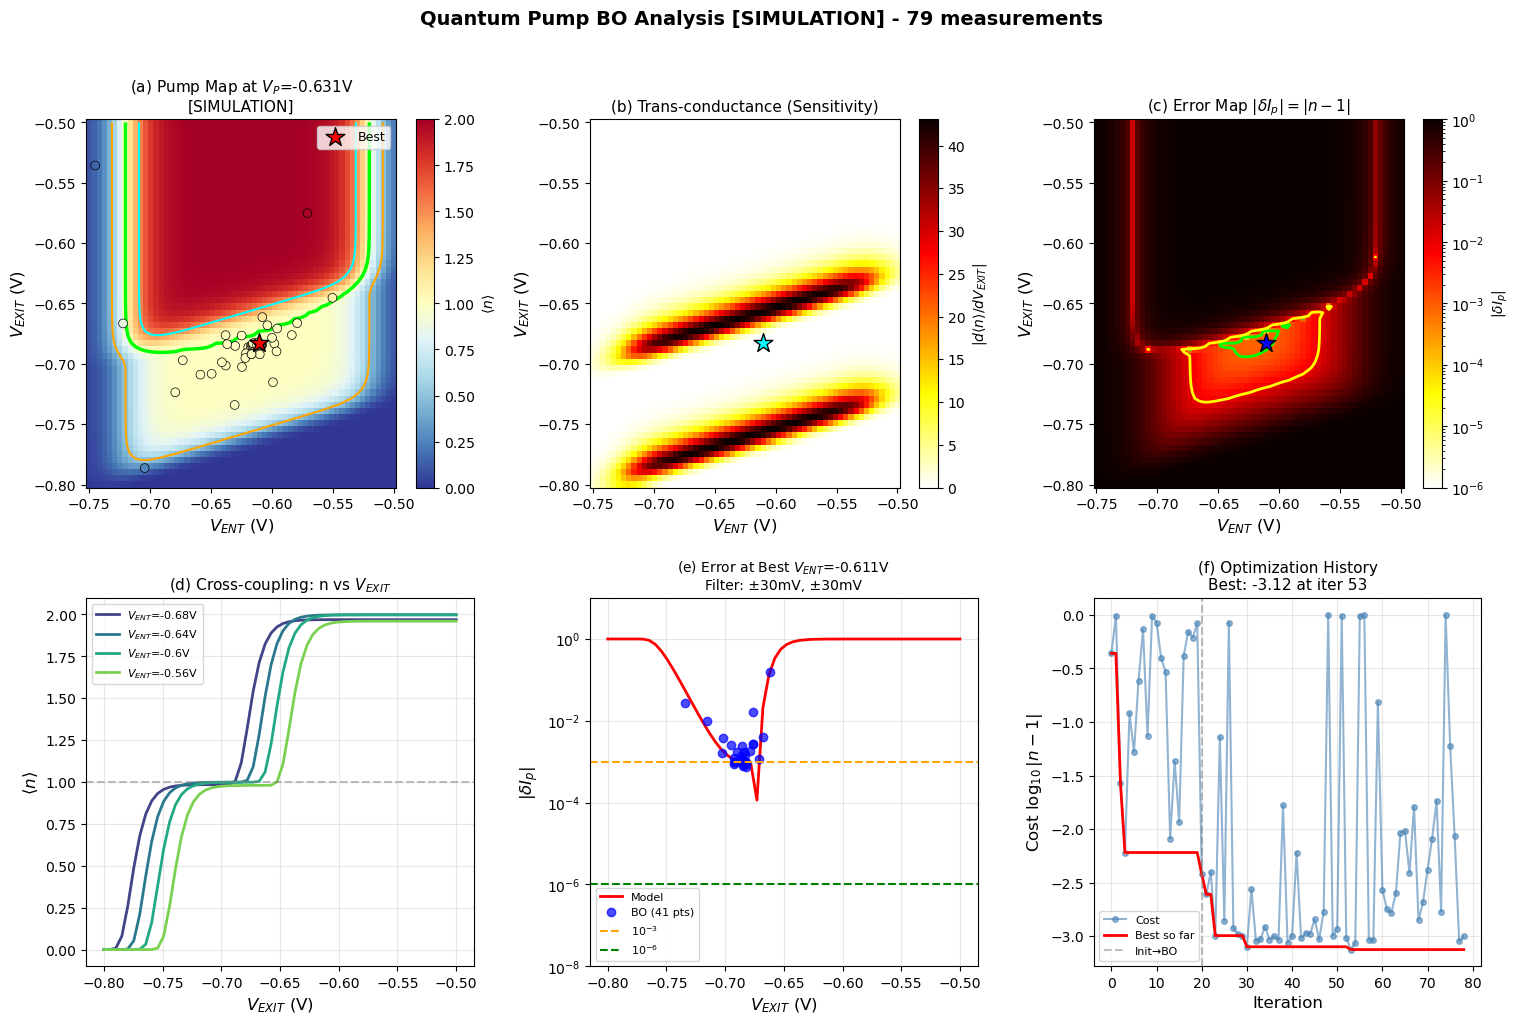

Saved: experiment_outputs/pump_analysis_SIMULATION_20260130_230342.png

Generating error analysis with GP...


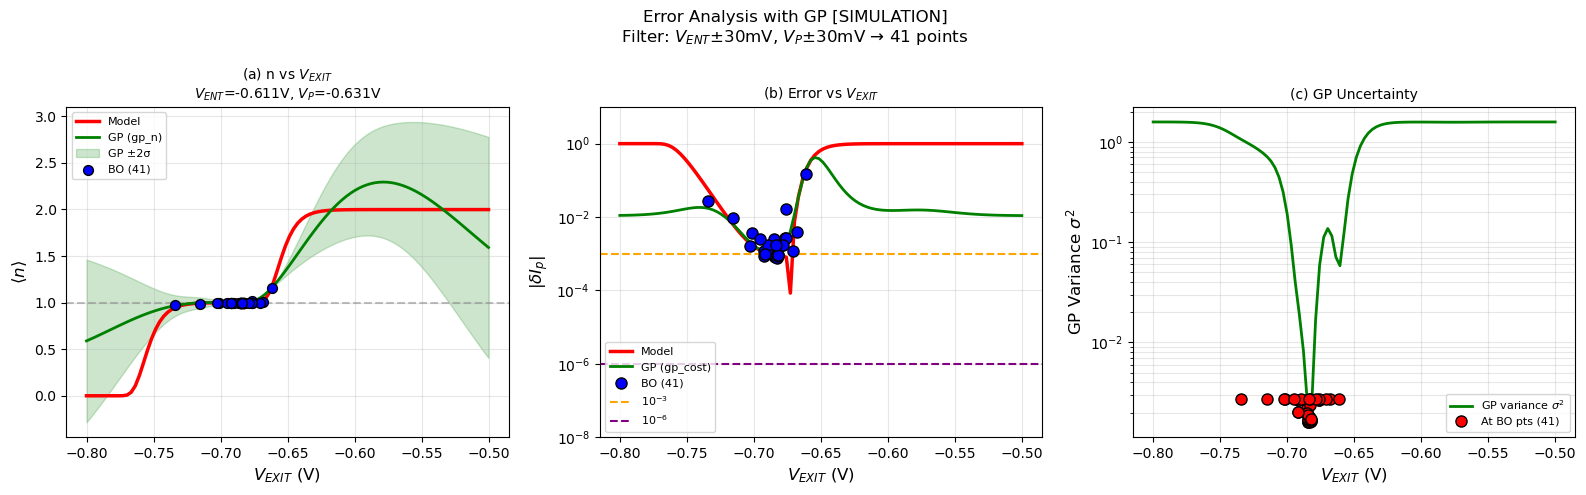

Saved: experiment_outputs/error_analysis_SIMULATION_20260130_230343.png


In [7]:
# Cell 7: Generate Visualizations

print('Generating 6-panel pump map analysis...')
fig1 = plot_pump_map_analysis(X_hist, y_hist, n_hist, bo, instr, cfg)

print('\nGenerating error analysis with GP...')
fig2 = plot_error_analysis_with_GP(X_hist, y_hist, n_hist, bo, instr, cfg)

In [8]:
# Cell 8: Save Data to CSV

def save_experiment_data(X_hist, y_hist, n_hist, config):
    """
    Save all experiment data to CSV files.
    """
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Main data
    df = pd.DataFrame({
        'iteration': np.arange(len(y_hist)),
        'V_ENT': X_hist[:, 0],
        'V_P': X_hist[:, 1],
        'V_EXIT': X_hist[:, 2],
        'n': n_hist,
        'delta_n': np.abs(n_hist - 1),
        'cost': y_hist,
        'phase': ['Init' if i < config.n_initial_points else 'BO' for i in range(len(y_hist))]
    })
    
    filepath = config.output_dir / f'experiment_data_{timestamp}.csv'
    df.to_csv(filepath, index=False)
    print(f'Saved: {filepath}')
    
    # Summary
    best_idx = np.argmin(y_hist)
    summary = pd.DataFrame({
        'Parameter': ['V_ENT_best', 'V_P_best', 'V_EXIT_best', 'n_best', 'delta_n_best', 'cost_best',
                      'total_measurements', 'n_initial', 'n_bo'],
        'Value': [X_hist[best_idx, 0], X_hist[best_idx, 1], X_hist[best_idx, 2],
                  n_hist[best_idx], np.abs(n_hist[best_idx]-1), y_hist[best_idx],
                  len(y_hist), config.n_initial_points, len(y_hist) - config.n_initial_points]
    })
    
    summary_path = config.output_dir / f'experiment_summary_{timestamp}.csv'
    summary.to_csv(summary_path, index=False)
    print(f'Saved: {summary_path}')
    
    return df, summary


df, summary = save_experiment_data(X_hist, y_hist, n_hist, cfg)
print('\nData preview:')
print(df.head(10))
print('\nSummary:')
print(summary)

Saved: experiment_outputs/experiment_data_20260130_230343.csv
Saved: experiment_outputs/experiment_summary_20260130_230343.csv

Data preview:
   iteration     V_ENT       V_P    V_EXIT         n   delta_n      cost phase
0          0 -0.597112 -0.717419 -0.627081  1.436315  0.436315 -0.360200  Init
1          1 -0.570790 -0.653191 -0.575171  1.983043  0.983043 -0.007428  Init
2          2 -0.630444 -0.624882 -0.734112  0.972954  0.027046 -1.567903  Init
3          3 -0.617265 -0.663450 -0.703415  0.993955  0.006045 -2.218638  Init
4          4 -0.721966 -0.650599 -0.666550  0.878601  0.121399 -0.915785  Init
5          5 -0.551282 -0.669863 -0.692670  0.947634  0.052366 -1.280947  Init
6          6 -0.724670 -0.677817 -0.540412  0.758960  0.241040 -0.617911  Init
7          7 -0.704250 -0.654381 -0.786347  0.263502  0.736498 -0.132828  Init
8          8 -0.534443 -0.721523 -0.553355  1.073345  0.073345 -1.134627  Init
9          9 -0.694936 -0.535906 -0.791515  0.025815  0.974185 -0.01

In [9]:
# Cell 9: Final Summary

X_hist = np.array(X_hist)
y_hist = np.array(y_hist)
n_hist = np.array(n_hist)

best_idx = np.argmin(y_hist)

print('='*70)
print('EXPERIMENT SUMMARY')
print('='*70)
print(f'Mode:               {instr.get_mode_string()}')
print(f'Total measurements: {len(y_hist)}')
print(f'\nBest Operating Point:')
print(f'  V_ENT:   {X_hist[best_idx, 0]:.6f} V')
print(f'  V_P:     {X_hist[best_idx, 1]:.6f} V')
print(f'  V_EXIT:  {X_hist[best_idx, 2]:.6f} V')
print(f'\nPerformance:')
print(f'  n:       {n_hist[best_idx]:.6f}')
print(f'  |n-1|:   {np.abs(n_hist[best_idx]-1):.2e}')
print(f'  Cost:    {y_hist[best_idx]:.4f}')
print(f'\nOutput Files:')
print(f'  Directory: {cfg.output_dir}')
for f in cfg.output_dir.glob('*'):
    print(f'    - {f.name}')
print('='*70)

EXPERIMENT SUMMARY
Mode:               SIMULATION
Total measurements: 79

Best Operating Point:
  V_ENT:   -0.610556 V
  V_P:     -0.630552 V
  V_EXIT:  -0.682600 V

Performance:
  n:       0.999249
  |n-1|:   7.51e-04
  Cost:    -3.1245

Output Files:
  Directory: experiment_outputs
    - experiment_data_20260130_230343.csv
    - pump_analysis_SIMULATION_20260130_230342.png
    - experiment_summary_20260130_230343.csv
    - error_analysis_SIMULATION_20260130_230343.png
